# Diagnostics

By calling ``DualBounds.summary()`` or ``DualBounds.diagnostics()``, one can learn about numerical errors, overfitting, or other problems that lead to loose statistical bounds. This tutorial explains how to interpret the diagnostic information and fix common problems.

The diagnostic output typically looks something like this:

|                         |      Lower |        Upper |
|:------------------------|-----------:|-------------:|
| Loss from gridsearch    |  0.042201  | -1.08621e-12 |
| Max leverage            |  0.0742045 |  0.0842585   |
| Worst dual AIPW summand | -0.395824  |  1.87443     |

The diagnostic quantities have the following interpretations.

## Loss from gridsearch

When $Y$ is continuous, to compute partial identification bounds, ``dualbounds`` does the following:

1. Discretize $Y(0)$ and $Y(1)$ into ``nvals0`` and ``nvals1`` values and compute optimal dual variables by solving a discrete optimal transport program.
2. Transport the discrete optimal dual variables back into a continuous space, typically via linear interpolation.
3. Apply a grid search to ensure that the optimal dual variables in the continuous space are dual-feasible in the sense described by [Ji et al. (2023)](https://arxiv.org/abs/2310.08115).

The grid search in Step 3 ensures that the final bounds are always statistically valid, even if the discrete approximation to the continuous space is poor. However, if the discrete approximation is poor, the bounds can become much looser. "Loss from gridsearch" estimates how much looser the bounds have become due to the gridsearch. For example, in the example at the top of this page:

- The lower "loss from gridsearch" is $0.04$, suggesting that the lower estimate would have been $0.04$ units larger without performing the gridsearch.
- The upper "loss from gridsearch" is $\approx 0$, suggesting that the grid search did not change the upper estimate.

If the loss from gridsearch is consequential, consider the following strategies:

1. Try increasing the ``nvals0`` and ``nvals1`` arguments in ``DualBounds.fit()``.
2. Try changing the ``interp_fn`` argument in ``DualBounds.fit()``.
3. At your own risk, you can set ``grid_search=0``, which disables the grid search. In theory, this can lead to invalid bounds, although in practice it does not usually cause problems.


Note that when $Y$ is discrete and ``discrete=True``, the loss from gridsearch will always equal zero since in this case the gridsearch is not necessary.

## Max leverage

The final dual bound estimates are computed as sample means of special "Dual AIPW summands":

$$\hat\theta_L = \frac{1}{n} \sum_{i=1}^n S_i^{\mathrm{lower}} \text{ and } \hat\theta_U = \frac{1}{n} \sum_{i=1}^n S_i^{\mathrm{upper}}, $$

where $\hat\theta_L$ and $\hat\theta_U$ are the lower and upper estimates. The maximum leverage is defined as the maximum normalized square deviation from the estimates:

$$\mathrm{MaxLeverage}_{\mathrm{lower}} = \max_{i \in [n]} \frac{(S_i^{\mathrm{lower}} - \hat\theta_L)^2}{\sum_j (S_j^{\mathrm{lower}} - \hat\theta_L)^2}$$

with the upper maximum leverage defined analagously. Intuitively, the maximum leverage measures how much one data-point contributes to the standard error. 

A few common explanations for high leverage points include:

- A heavy-tailed outcome
- Heavy-tailed covariates
- Excessively small/large propensity scores
- An overfit/mispecified outcome model
- Numerical instabilities/numerical problems

Calling ``DualBounds.diagnostics(plot=True)`` can help one visually assess which of these explanations is accurate. We give an example of this below when bounding $E[|Y(1) - Y(0)|]$, the absolute treatment effect.

In [1]:
# import packages
import sys; sys.path.insert(0, "../../../")
import numpy as np; np.random.seed(123)
import scipy.stats
import dualbounds as db
from dualbounds.generic import DualBounds

# Define the estimand
f = lambda y0, y1, x: np.abs(y1 - y0)
# heavy-tailed Y
data = db.gen_data.gen_regression_data(n=500, p=50, sample_seed=123)
data['y'] += scipy.stats.t(df=2).rvs(size=500)
# Fit dualbounds
gdb = db.generic.DualBounds(
    f=f, 
    outcome=data['y'], 
    treatment=data['W'], 
    propensities=data['pis'],
    covariates=data['X'],
).fit(verbose=False)

Here, this data-set has some moderately high leverage points, but it looks like the high-leverage points correspond to very large outcome values---in other words, the outcome is simply heavy-tailed, and some large leverage values are inevitable.

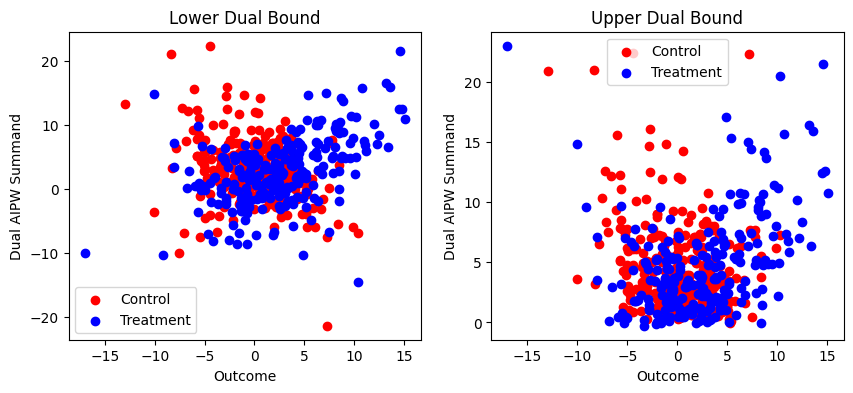

|                         |       Lower |        Upper |
|:------------------------|------------:|-------------:|
| Loss from gridsearch    |  0.00575747 | -4.66942e-14 |
| Max leverage            |  0.0435221  |  0.0412186   |
| Worst dual AIPW summand | -0.0427468  |  0.0460309   |


In [2]:
print(gdb.diagnostics(plot=True).to_markdown())

## Worst dual AIPW summand

The worst dual AIPW summand is the maximum (resp. minimum) value of the AIPW summands for the upper (resp. lower) bounds:

$$\mathrm{WorstCase}^{\mathrm{lower}} = \min_{i} \frac{S_i^{\mathrm{lower}}}{n} $$

$$\mathrm{WorstCase}^{\mathrm{upper}} = \max_{i} \frac{S_i^{\mathrm{upper}}}{n} $$

In other words, these quantities tell you how much the worst data-point loosened the partial identification bounds. Like leverage scores, they are helpful in telling you when a model has overfit or there is an outlier in the data. For example, consider the following dataset, where there is a huge outlier in the covariates, leading to horrible predictions for that data-point:

In [3]:
# Create a single enormous outlier in the covariates
data['X'][-1] = 1e6
# Poorly specified model, heavy-tailed Y
gdb_outlier = db.generic.DualBounds(
    f=f, 
    outcome=data['y'], 
    treatment=data['W'], 
    propensities=data['pis'],
    covariates=data['X'],
).fit(verbose=False)
print(gdb_outlier.results().to_markdown())

|            |   Lower |   Upper |
|:-----------|--------:|--------:|
| Estimate   | 1028.08 | 1031.97 |
| SE         | 1024.84 | 1024.83 |
| Conf. Int. | -980.56 | 3040.6  |


We can see that the results have huge standard errors. To understand why, we use the diagnostic plot:

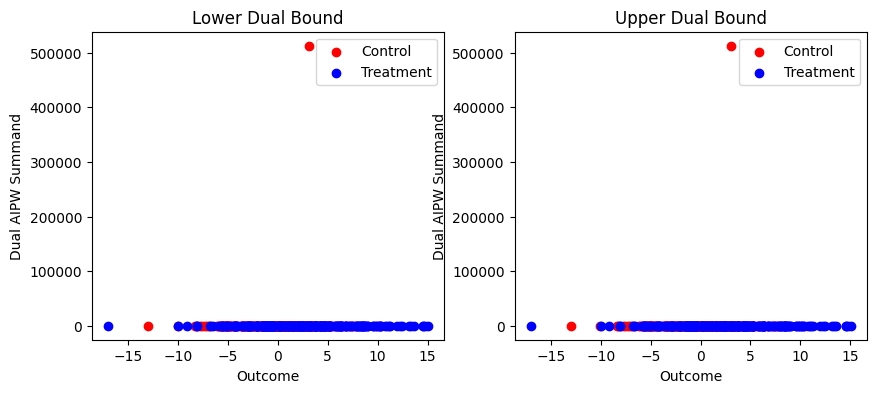

|                         |      Lower |          Upper |
|:------------------------|-----------:|---------------:|
| Loss from gridsearch    |  0.0102479 |   -1.51896e-12 |
| Max leverage            |  0.998     |    0.998       |
| Worst dual AIPW summand | -0.0851198 | 1025.87        |


In [4]:
print(gdb_outlier.diagnostics(plot=True).to_markdown())

Clearly, there is one data-point whose outcome takes a moderate value but whose dual AIPW summand takes a huge value. This is indicative of an outlier in the covariates, a poorly specified model, or a numerical error.